# MODEL BUILDING 

In [1]:
import pandas as pd

# Loading datasets
train_df = pd.read_csv('Scaled_train.csv')
test_df = pd.read_csv('Scaled_test.csv')


## Train Baseline Model

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# preparing data
X_train = train_df.drop('Survived', axis=1)
y_train =  train_df['Survived']
X_test = test_df

In [3]:
# Logistic Regression
lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [4]:
# Random forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

## Evaluate Baseline Model

In [5]:
from sklearn.model_selection import cross_val_score

# Cross-validation function
def evaluate_cv(model, X, y, model_name):
    print(f"\n{model_name} CV performance")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        scores = cross_val_score(model, X, y, cv=5, scoring=metric)
        print(f"{metric.capitalize()}: {scores.mean():.3f} (±{scores.std():.3f})")

evaluate_cv(lr, X_train, y_train, "Logistic regression")
evaluate_cv(rf, X_train, y_train, "Random Forest Classifier")


Logistic regression CV performance
Accuracy: 0.807 (±0.020)
Precision: 0.732 (±0.031)
Recall: 0.789 (±0.071)
F1: 0.757 (±0.034)
Roc_auc: 0.863 (±0.024)

Random Forest Classifier CV performance
Accuracy: 0.802 (±0.034)
Precision: 0.754 (±0.046)
Recall: 0.722 (±0.068)
F1: 0.736 (±0.051)
Roc_auc: 0.856 (±0.041)


### Findings:
##### Logistic Regression seems to slightly outperform Random Forest Classifie
##### However, Random Forest might be the better choice for precision (minimizing false positives

# MODEL OPTIMIZATION

## Hyperparameter Tuning:

In [11]:
from sklearn.model_selection import GridSearchCV

# Random Forest tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid,
    cv=5,
    scoring='f1'
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
evaluate_cv(best_rf, X_train, y_train, "Tuned Random Forest")

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Tuned Random Forest CV performance
Accuracy: 0.829 (±0.027)
Precision: 0.786 (±0.036)
Recall: 0.766 (±0.075)
F1: 0.773 (±0.044)
Roc_auc: 0.869 (±0.037)


## Feature Selection (Advanced)

Title_Mr      0.204311
Fare          0.178149
Sex_male      0.159905
Age           0.131329
Pclass        0.094283
FamilySize    0.055725
Title_Miss    0.048313
SibSp         0.033989
Title_Mrs     0.029534
Parch         0.017561
Embarked_S    0.017457
IsAlone       0.012608
Embarked_Q    0.008852
Title_Rare    0.007984
dtype: float64


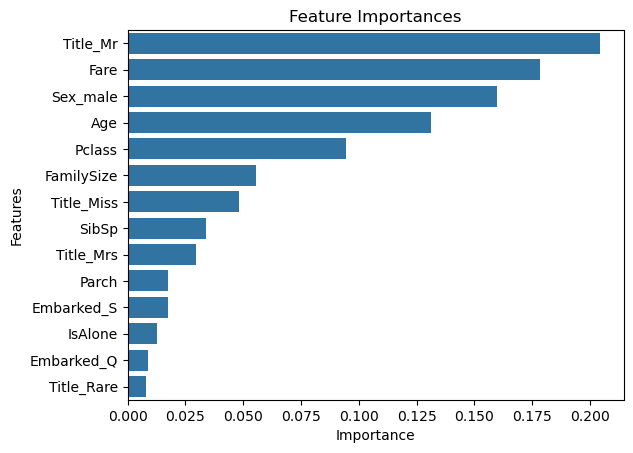

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
# Feature importance
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False))

importances_sorted = importances.sort_values(ascending=False)


# Plot
sns.barplot(x=importances_sorted.values, y=importances_sorted.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## Ensemble Methods

In [20]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    random_state=42,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)
)
xgb.fit(X_train, y_train)
evaluate_cv(xgb, X_train, y_train, "XGBoost")


XGBoost CV performance
Accuracy: 0.810 (±0.026)
Precision: 0.753 (±0.047)
Recall: 0.760 (±0.036)
F1: 0.755 (±0.028)
Roc_auc: 0.857 (±0.028)


# FINAL MODEL EVALUATION

## Error Analysis

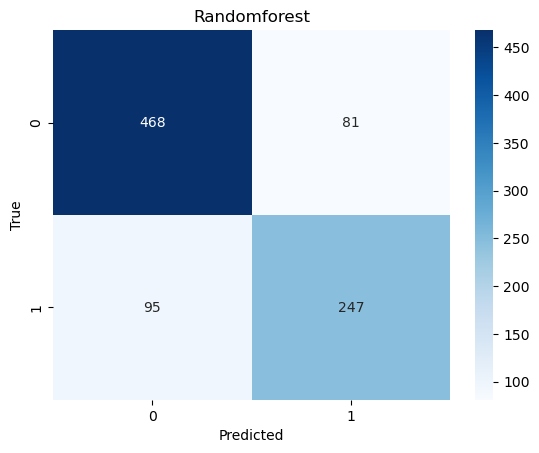

In [24]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred_cv = cross_val_predict(rf, X_train, y_train, cv=5)
cm = confusion_matrix(y_train, y_pred_cv)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Randomforest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

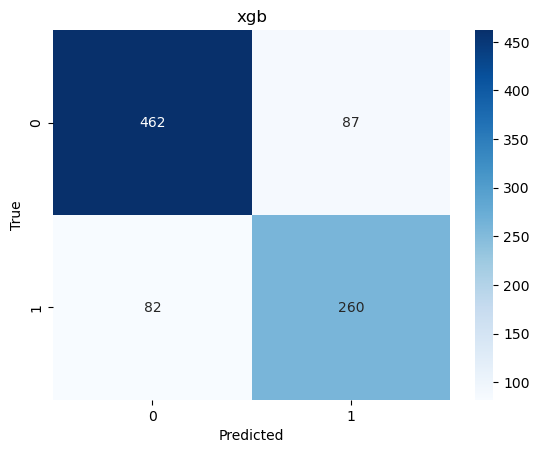

In [25]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred_cv = cross_val_predict(xgb, X_train, y_train, cv=5)
cm = confusion_matrix(y_train, y_pred_cv)
plt.title('xgb')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

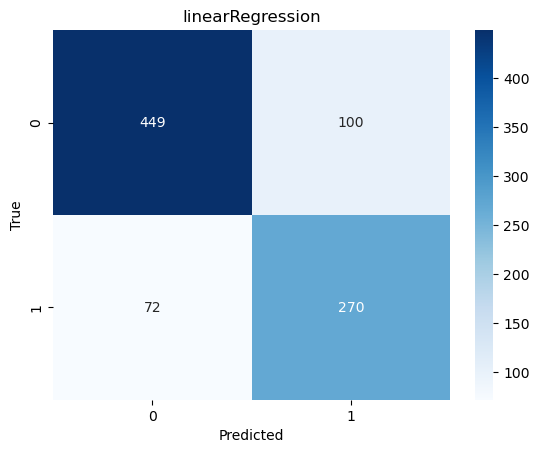

In [26]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred_cv = cross_val_predict(lr, X_train, y_train, cv=5)
cm = confusion_matrix(y_train, y_pred_cv)
plt.title('linearRegression')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [30]:
 best_model = best_rf.fit(X_train, y_train)

## Predict on test.csv

In [38]:
test_data = pd.read_csv('test.csv')
test_passenger_ids = test_data['PassengerId']

                            
y_pred_test = best_model.predict(X_test)

# Create submission
submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': y_pred_test
})
submission.to_csv('submission.csv', index=False)

## Saving Artifacts

In [40]:
import joblib

joblib.dump(best_model, 'titanic_model.pkl')


['titanic_model.pkl']